In [19]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import BSpline
import time
from scipy.interpolate import splprep, splev
from scipy.stats import uniform,norm

import PIC_Solver
import PoissonSolvers

import matplotlib.animation as animation
from IPython import display

In [20]:
######  Define the parameters  #######

## Positions
k_param = 0.5 # wave number
L_x = 2*np.pi/k_param # Distance in positions direction
N_x = 128 # Number of slots in the x direction
print('L_x: ',L_x)

## Velocities
L_v = 10 # Distance in velocities direction
v_min = -L_v/2 # Min velocity
v_max = L_v/2 # Max velocity
N_v = 256 # Number of slots in the v direction 

## Time
T_max = 20 # Max integration time
M = 200 # Number of iterations

## Particle information
N_k = int(5e4) # Number of markers (particles)
q = -1 # Electron charge (adimensional)
mass = 1 # Electron mass (adimensional)

# Spline degree
spl_degree = 3

L_x:  12.566370614359172


In [21]:
# Velocity distribution parameters:
mean_v = 0
sigma_v = 1
v_params = [mean_v, sigma_v]
# Positions distribution parameters:
mean_x = L_x/2
sigma_x = 2.5
x_params = [mean_x, sigma_x]

In [22]:
def sampling_dist(x,v):
    dist1 = 1.0/(np.sqrt(2*np.pi*sigma_v**2)) * np.exp(-(v-mean_v)**2/(2*sigma_v**2))
    dist2 = 1.0/(np.sqrt(2*np.pi*sigma_v**2)) * np.exp(-(x-mean_x)**2/(2*sigma_x**2))
    return dist1*dist2

In [23]:
def maxwell_control_var(v):
    '''Variable control function'''
    return 1.0/(np.sqrt(2*np.pi*sigma_v**2)) * np.exp(-(v-mean_v)**2/(2*sigma_v**2))

In [24]:
particle_x = norm.rvs(size = N_k, loc = mean_x, scale = sigma_x)
particle_v = norm.rvs(size = N_k, loc = mean_v, scale = sigma_v)

In [25]:
obj = PIC_Solver.PIC(N_k, q, mass, 0.0, L_x, N_x, 'normal', x_params,v_min, v_max, N_v, 'normal', v_params, T_max,
                     M, sampling_dist, maxwell_control_var, spl_degree, 'PIC_Landau')

In [26]:
dx = obj.dx # position step
print('dx: ',dx)

dv = obj.dv # velocity step
print('dv: ',dv)

dt = obj.dt # time step
print('dt: ',dt)

dx:  0.09817477042468103
dv:  0.0390625
dt:  0.1


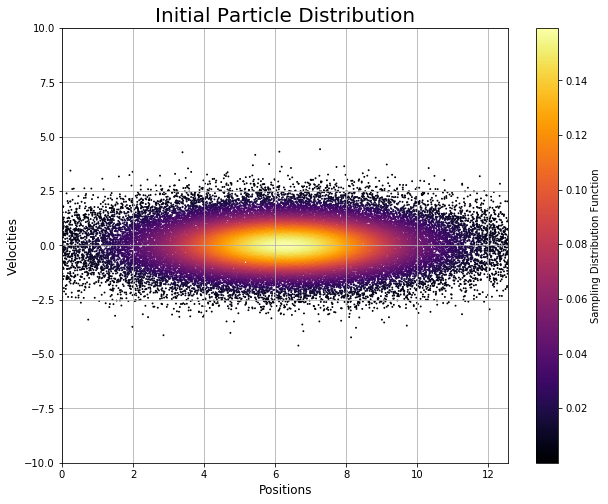

In [27]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Positions',fontsize = 'large')
ax.set_ylabel('Velocities',fontsize = 'large')
s = ax.scatter(obj.positions_sampling,obj.velocities_sampling  ,s=0.8,
               c = sampling_dist(obj.positions_sampling ,obj.velocities_sampling),cmap='inferno')
plt. title('Initial Particle Distribution',fontsize = 20)
plt.grid()
fig.colorbar(s ,label = 'Sampling Distribution Function')
plt.xlim([0, L_x])
plt.ylim([-10, 10])
plt.show()

In [14]:
start_time = time.time()

obj.run_iteration()

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  12.557216330369313


In [28]:
data_pic = np.loadtxt("PIC_Landau.txt")
data_pic.shape

(402, 50000)

In [29]:
data_pic = data_pic.reshape(M + 1, 2 , N_k)
data_pic.shape

(201, 2, 50000)

In [30]:
t_grid = obj.grid_points(0.0, T_max, dt)

In [31]:
init_pos = data_pic[0][0]
init_vel = data_pic[0][1]

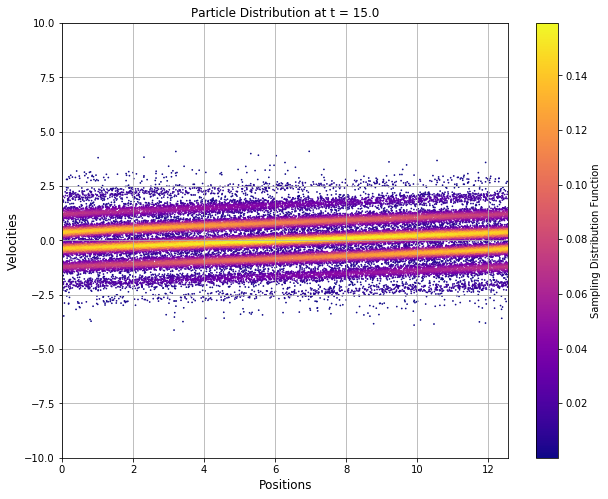

In [32]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Positions',fontsize = 'large')
ax.set_ylabel('Velocities',fontsize = 'large')
time_idx = 150
s = ax.scatter(data_pic[time_idx][0], data_pic[time_idx][1], s = 0.5,
              c = sampling_dist(init_pos,init_vel),cmap='plasma')
plt. title(f'Particle Distribution at t = {t_grid[time_idx]}')
plt.grid()
fig.colorbar(s ,label = 'Sampling Distribution Function')
plt.xlim([0, L_x])
plt.ylim([-10, 10])
plt.show()

In [33]:
time_plot = [0, 40, 80, 120, 160, 200] #times to plot

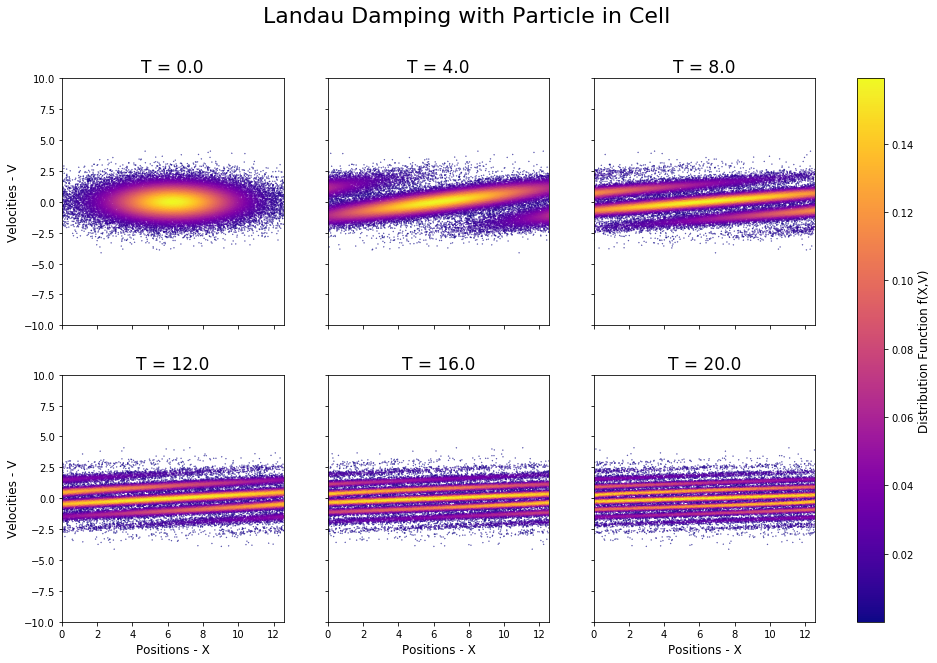

In [49]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Landau Damping with Particle in Cell',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].scatter(data_pic[time_plot[ti]][0], data_pic[time_plot[ti]][1], s = 0.1,
                            c = sampling_dist(init_pos,init_vel),cmap='plasma')
        ax[i,j].set_title(f'T = {time_plot[ti]*dt}',fontsize = 17) # create title
        ax[i,j].set_xlim([0, L_x])
        ax[i,j].set_ylim([-L_v, L_v])
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()